## Analysis Results

#### Load Model

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
from IPython import display

In [2]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [3]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [4]:
OUTPUT_CHANNELS = 3

In [5]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()

In [6]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

In [7]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [8]:
checkpoint_dir = '../assets/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [9]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [10]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    return test_input[0], tar[0], prediction[0]

#### Load Dataset

In [11]:
# Load ground truth image to use
ground_truth_images_dir = '../assets/ground_truth_image'

def load_tif_image(tif, index):
    tif.seek(index)
    return np.array(tif)

idx = np.arange(256)
ground_truth_images = []

for i in np.arange(16):
    tif_path = os.path.join(ground_truth_images_dir, f"bse_stack_{i}_processed.tif")
    tif_image = Image.open(tif_path)

    for j in idx:
        ground_truth_images.append(load_tif_image(tif_image, j))

ground_truth_images = np.array(ground_truth_images)

if len(ground_truth_images.shape) == 3:
    ground_truth_images = np.stack([ground_truth_images] * 3, axis=-1)

print(f'Size of the ground truth images: {ground_truth_images.shape}')

Size of the ground truth images: (4096, 256, 256, 3)


In [12]:
# Load curtained image to use
curtained_path = '../assets/curtained_image'

def load_tif_image(tif, index):
    tif.seek(index)
    return np.array(tif)

idx = np.arange(256)
curtained_images = []

for i in np.arange(16):
    tif_path = os.path.join(curtained_path, f"hm_stack_{i}_processed.tif")
    tif_image = Image.open(tif_path)

    for j in idx:
        curtained_images.append(load_tif_image(tif_image,j))

curtained_images = np.array(curtained_images)

if len(curtained_images.shape) == 3:
    curtained_images = np.stack([curtained_images] * 3, axis=-1)

print('Size of the ground truth images:', curtained_images.shape)

Size of the ground truth images: (4096, 256, 256, 3)


In [13]:
def load(input_image, target_image):
    input_image = tf.cast(input_image, dtype=tf.float32)
    target_image = tf.cast(target_image, dtype=tf.float32)

    return input_image, target_image

In [14]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [15]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [16]:
# The facade training set consist of 400 images
BUFFER_SIZE = 10
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [17]:
def load_image_test(input_image, real_image):
  input_image, real_image = load(input_image, real_image)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [18]:
try:
    test_dataset = tf.data.Dataset.from_tensor_slices((curtained_images[3500:], ground_truth_images[3500:]))
    
except tf.errors.InvalidArgumentError:
    print('There are not enough images to create the test dataset')

test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [19]:
target_position = 93

specific_image_dataset = test_dataset.skip(target_position).take(1)

for inp, tar in specific_image_dataset:
    input, target, prediction = generate_images(generator, inp, tar)

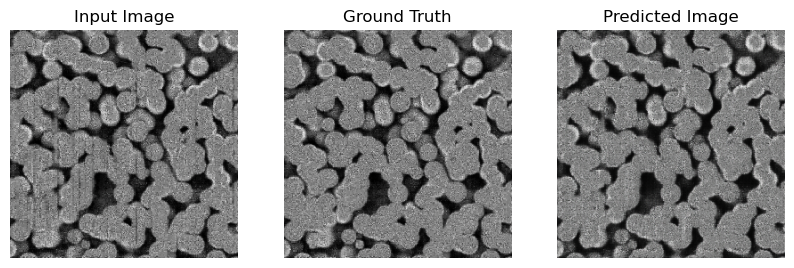

In [20]:
display_list = [input, target, prediction]
title = ['Input Image', 'Ground Truth', 'Predicted Image']

plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


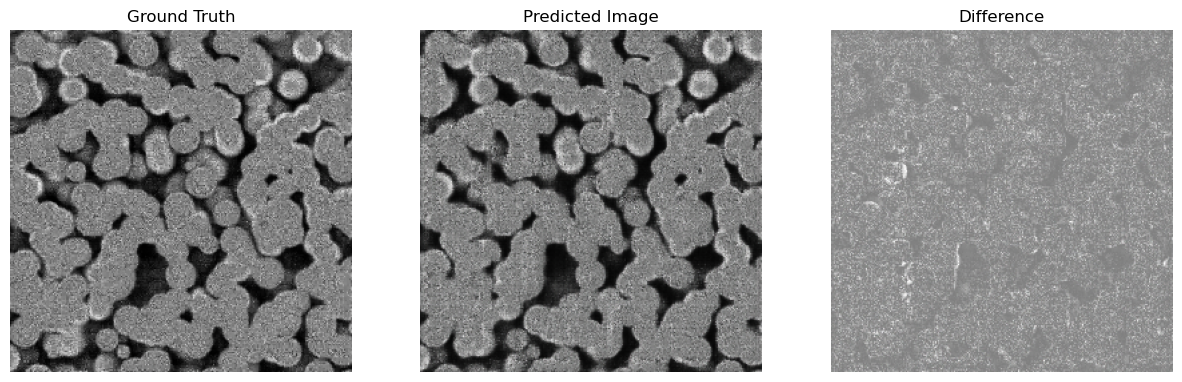

In [21]:
difference = np.abs(target - prediction)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Ground Truth")
plt.imshow(target * 0.5 + 0.5)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Image")
plt.imshow(prediction * 0.5 + 0.5)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Difference")
plt.imshow(difference * 0.5 + 0.5)
plt.axis('off')

plt.show();

In [22]:
# Calcula el MSE
mse = tf.reduce_mean(tf.square(target - prediction))
print(f"Mean Squared Error (MSE): {mse.numpy()}")

# Calcula el PSNR
psnr = tf.image.psnr(target, prediction, max_val=1.0)
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr.numpy()} dB")

# Calcula el SSIM
ssim = tf.image.ssim(target, prediction, max_val=1.0)
print(f"Structural Similarity Index (SSIM): {ssim.numpy()}")

Mean Squared Error (MSE): 0.038432978093624115
Peak Signal-to-Noise Ratio (PSNR): 14.152958869934082 dB
Structural Similarity Index (SSIM): 0.3407628834247589
